In [2]:
import sys
import os

# Enable horizontal scrolling for large outputs
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Calculate the path to your_package
notebook_dir = os.getcwd()
package_dir = os.path.dirname(notebook_dir)

# Add this path to sys.path
if package_dir not in sys.path:
    sys.path.append(package_dir)

In [3]:
from config import parse_args
from main import *

commandline_args = '--task_path=TreeSCAN/v10/jump_split/separate_to_leaves --blackboard_steps=20 --lr=1e-4 --steps=3e4 --ctrl_hidden_dim=256 --wd=0 --batch_size=128 --train_log_freq=20 --transformer_nheads=4 --router_dropout=0 --max_tree_depth=8 --optim_beta2=.95 --d_filler=64 --num_workers=4 --sparse --max_filled_roles=256 --log_level=INFO --custom_memory=1 --hardcode_cons_root_token="<NT>" --output_lowercase=0 --add_eob_to_memory=1 --cons_only=1 --early_stop_epochs=100 --use_wandb --wandb_group=scan --wandb_name=scan_v10_untied_embeddings --learn_filler_embed=0 --validate_every_num_epochs=3 --filler_map_location=None --entropy_regularization_coefficient=0 --tied_embeddings=0'
# XT needs the <NT> token wrapped in "", remove it if it's there
commandline_args = commandline_args.replace('"<NT>"', '<NT>')
args = parse_args(commandline_args.split())
args.batch_size = 1

checkpoint_file = '/tmp/run1008.0/run1008.0/mirrored/out/checkpoint.pt'

task_path = prepare_data_files(args)
device = 'cpu'
is_ddp = False
main_process = True
data_loaders, input_lang, output_lang = data.prepare_data_loaders(
    task_path,
    args.max_tree_depth,
    args.add_eob_tokens,
    is_ddp,
    args.batch_size,
    args.num_workers,
    data_filter=args.data_filter,
    max_train_examples=args.max_train_examples,
    output_lowercase=args.output_lowercase,
    add_eob_to_memory=args.add_eob_to_memory,
)
'''
for index, vocab in enumerate(index2vocab):
    #print(f'{index}: {vocab}')
    if vocab == 'jump':
        jump_input_index = index
    elif vocab == 'I_JUMP':
        jump_output_index = index
    elif vocab == 'walk':
        walk_input_index = index
    elif vocab == 'I_WALK':
        walk_output_index = index

if args.output_lowercase:
    jump_output_index = jump_input_index
    walk_output_index = walk_input_index
print(f'jump_input_index: {jump_input_index}')
print(f'jump_output_index: {jump_output_index}')
print(f'walk_input_index: {walk_input_index}')
print(f'walk_output_index: {walk_output_index}')
'''
max_input_length = -1
for name, loader in data_loaders.items():
    if loader:
        max_input_length = max(max_input_length, loader.dataset.max_input_length)


using LOCAL dataset/task files found at: /Users/psoulos/.data/TreeSCAN/v10/jump_split/separate_to_leaves
Max depth seen in file: 8
10012 training examples
Max depth seen in file: 8
3336 valid examples
Max depth seen in file: 8
7706 test examples


In [21]:
from TPR_utils import TPR, decoded_tpr_to_tree_fn
from models import DiffTreeMachine

if args.use_vocab_info:
    vocab_info = data.get_vocab_info(args.task_path, index2vocab,)
else:
    vocab_info = {
        'unary': (),
        'binary': (),
        'terminal': ('<EOB>',)
    }

tpr = TPR(
    args,
    num_input_fillers=len(input_lang.ind2vocab),
    num_output_fillers=len(output_lang.ind2vocab),
    num_roles=2 ** args.max_tree_depth,
    d_filler=args.d_filler,
    d_role=args.d_role,
    filler_emb_gain=args.filler_emb_gain,
    learn_empty_filler=args.learn_empty_filler,
    tied_embeddings=args.tied_embeddings,
    empty_filler_initialization=args.empty_filler_initialization,
    device=device,
    sparse=args.sparse
).to(device=device)


hardcode_cons_root_index = None
if args.hardcode_cons_root_token:
    if args.hardcode_cons_root_token == '-1':
        hardcode_cons_root_index = -1
    else:
        vocab2index = output_lang.vocab2ind
        assert args.hardcode_cons_root_token in vocab2index, (
            f'The token {args.harcode_cons_root_token} is not in the '
            f'vocab.')
        hardcode_cons_root_index = vocab2index[args.hardcode_cons_root_token]
    logger.info(
        f'Hardcoding the root token to {args.hardcode_cons_root_token} with index'
        f' {hardcode_cons_root_index}'
    )


dtm = DiffTreeMachine(
        args.d_filler,
        args.d_role,
        args.ctrl_hidden_dim,
        args.blackboard_steps,
        args.ctrl_type,
        args.router_hidden_dim,
        nhead=args.transformer_nheads,
        dropout=args.router_dropout,
        transformer_activation=args.transformer_activation,
        transformer_norm_first=args.transformer_norm_first,
        op_dist_fn=args.op_dist_fn,
        arg_dist_fn=args.arg_dist_fn,
        filler_map_type=args.filler_map_type,
        filler_map_location=args.filler_map_location,
        n_conv_kernels=args.n_conv_kernels,
        input_lang=input_lang,
        output_lang=output_lang,
        tpr=tpr,
        predefined_operations_are_random=args.predefined_operations_are_random,
        include_empty_tpr=args.include_empty_tpr,
        root_prediction_is_attn=args.root_prediction_is_attn,
        sparse=args.sparse,
        filler_threshold=args.filler_threshold,
        transformer_layers_per_step=args.agent_layers_per_step,
        max_filled_roles=args.max_filled_roles,
        hardcode_cons_root_index=hardcode_cons_root_index,
        max_input_length=max_input_length,
        cons_only=args.cons_only,
).to(device=device)

map_location = device
dtm.load_state_dict(torch.load(checkpoint_file,
                               map_location=map_location)['model'])
dtm.eval()

optimizer, scheduler = setup_optimizer_and_scheduler(dtm, args)

trainer = Trainer(
    dtm,
    tpr,
    data_loaders['train'],
    data_loaders['valid'],
    data_loaders['test'],
    optimizer,
    args.epoch,
    args.steps,
    args.num_warmup_steps,
    main_process,
    is_ddp,
    decoded_tpr_to_tree_fn(args.tpr_loss_type, sparse=args.sparse),
    torch.nn.CrossEntropyLoss(),
    device,
    output_lang.ind2vocab,
    vocab_info,
    args.use_wandb,
    args.validate_every_num_epochs,
    args.train_log_freq,
    early_stop_epochs=args.early_stop_epochs,
    pad_idx=0,
    sparse=args.sparse,
    scheduler=scheduler,
    gclip=args.gclip,
    lr=args.lr,
    out_dir=args.out_dir,
    checkpoint_file=args.checkpoint_file,
    use_custom_memory=args.custom_memory,
    cross_entropy_weighting=args.cross_entropy_weighting,
    entropy_regularization_coefficient=args.entropy_regularization_coefficient,
)

test_iter = iter(data_loaders['test'])

Trainable params: 16521104


In [ ]:
import torch

def replace_jump(batch, jump_input_index, jump_output_index, replacement_input_index, replacement_output_index):
    batch['input_fillers'][batch['input_fillers'] == jump_input_index] = replacement_input_index
    batch['output_fillers'][batch['output_fillers'] == jump_output_index] = replacement_output_index
    return batch

def print_correct_output(batch):
    output_filler_indices = batch['output_fillers']
    batch_size = output_filler_indices.shape[0]
    output_role_indices = batch['output_roles']
    output_batch_indices = torch.nonzero(output_role_indices, as_tuple=True)[0]
    output_filler_indices = output_filler_indices[output_role_indices != 0]
    output_role_indices = output_role_indices[output_role_indices != 0]
    target = torch.sparse_coo_tensor(indices=torch.stack((output_batch_indices, output_role_indices)),
                                     values=output_filler_indices, size=(batch_size,
                                                                         tpr.num_roles)).coalesce()

    formatted_tree = TreePrettyPrinter(Tree.fromstring(
        batch_symbols_to_node_tree(SparseTPR(target.indices(), target.values()), index2vocab,
                                   terminal_vocab=vocab_info['terminal'],
                                   unary_vocab=vocab_info['unary'], )[0].str(), ))
    print('Correct output:\n{}'.format(formatted_tree.text()))

In [5]:
batch = next(test_iter)
print(batch)
_ = trainer.process_batch(batch, debug=True)
print_correct_output(batch)
print(replace_jump(batch, jump_input_index, jump_output_index, walk_input_index, walk_output_index))
_ = trainer.process_batch(batch, debug=True)
print_correct_output(batch)

{'input_fillers': tensor([[[ 1,  0,  0],
         [14,  1,  1],
         [ 3,  1,  1],
         [ 4,  1,  1],
         [11,  1,  1],
         [ 6,  1,  1],
         [12,  1,  1],
         [ 3,  1,  1],
         [ 4,  1,  1],
         [ 5,  1,  1]],

        [[ 1,  0,  0],
         [ 9,  1,  1],
         [ 5,  1,  1],
         [10,  1,  1],
         [14,  1,  1],
         [13,  1,  1],
         [ 8,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]]), 'input_roles': tensor([[[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]), 'output_fillers': tensor([[2, 2, 2, 2, 3, 1, 1, 3, 1, 1, 2, 8, 1, 1, 3, 1, 1, 2, 2, 3, 1, 1, 8, 1

NameError: name 'index2vocab' is not defined

In [ ]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('look twice and walk opposite left twice'.split()), add_eob_to_memory=args.add_eob_to_memory)
out_tree = text_tree_to_node(build_leaves_tree('I_JUMP I_JUMP'.split()))
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
print_correct_output(input_)

In [26]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('jump twice and walk opposite right twice'.split()), add_eob_to_memory=args.add_eob_to_memory)
out_tree = text_tree_to_node(build_leaves_tree('I_JUMP I_JUMP'.split()))
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
print(_)

output.indices(): tensor([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
          43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
          57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
          71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
          85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
          99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
         113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
         127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
         141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
         155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
         169, 170, 171, 172, 173, 

In [13]:
torch.dot(tpr.out.weight[8],tpr.filler_emb.weight[5])

tensor(-1.3998, grad_fn=<DotBackward0>)

In [ ]:
logits = (((tpr.filler_emb.weight[17]*0 +tpr.filler_emb.weight[9]*0 + tpr.filler_emb.weight[17]*1) @ dtm.filler_map.weight) + dtm.filler_map.bias) @ tpr.filler_emb.weight.T
softmax = logits.softmax(dim=0)
for i in range(len(logits)):
    print(f'{i:2}: {logits[i]:.2f}\t{softmax[i]:.2f}')
print(torch.argmax(logits))

In [ ]:
for i, filler in enumerate(zip(output_lang.ind2vocab, tpr.out.weight.norm(dim=-1))):
    print(f'{i}. {filler[0]} {filler[1]}')


In [61]:
for i in range(tpr.out.weight.shape[0]):
    print(f'{i}. {(tpr.filler_emb.weight[14]*.7+tpr.filler_emb.weight[4]*.3) @ tpr.out.weight[i]}')

0. 0.05614493787288666
1. -2.089639663696289
2. -1.2022676467895508
3. 9.216145515441895
4. -1.6666622161865234
5. 1.8595645427703857
6. -3.9733166694641113
7. -3.09982967376709
8. 9.516129493713379


In [63]:
for i in range(tpr.out.weight.shape[0]):
    print(f'{i}. {tpr.filler_emb.weight[7] @ tpr.out.weight[i]}')

0. -0.1817692518234253
1. -14.401993751525879
2. -5.542102336883545
3. -4.813035011291504
4. -4.942420959472656
5. -4.080390930175781
6. 26.237991333007812
7. -4.783176422119141
8. -7.665806770324707


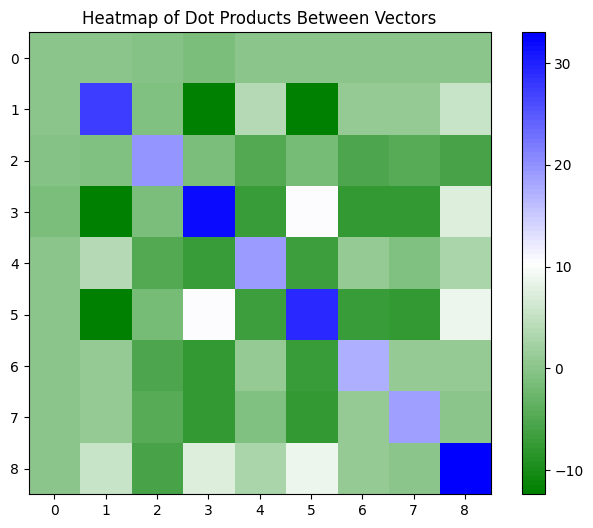

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Generating a new colormap
colors = ["green", "white", "blue"]  # green for negative, white for zero, blue for positive
n_bins = [3]  # Discretizes the interpolation into bins
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)



# Compute the dot product matrix
dot_product_matrix = tpr.out.weight @ tpr.out.weight.T

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(dot_product_matrix.detach(), cmap=cm, interpolation='nearest')
plt.title("Heatmap of Dot Products Between Vectors")
plt.colorbar()
plt.show()

In [24]:
for i in range(len(output_lang.ind2vocab)):
    print(f'{i}.{output_lang.ind2vocab[i]}: {tpr.out.weight[i] @ tpr.out.weight.T}')

0.<PAD>: tensor([ 0.2935,  0.3146, -0.2211, -1.1780,  0.2211,  0.2286,  0.1583,  0.1369,
         0.0795], grad_fn=<SqueezeBackward4>)
1.<EOB>: tensor([  0.3146,  27.2820,  -0.6400, -12.3706,   3.7373, -11.9948,   1.0519,
          0.8123,   5.5325], grad_fn=<SqueezeBackward4>)
2.<NT>: tensor([-0.2211, -0.6400, 19.8001, -1.1370, -4.6788, -1.7578, -5.3453, -4.6481,
        -5.7516], grad_fn=<SqueezeBackward4>)
3.I_TURN_RIGHT: tensor([ -1.1780, -12.3706,  -1.1370,  31.8403,  -7.0545,  10.5052,  -7.6417,
         -7.7238,   7.2716], grad_fn=<SqueezeBackward4>)
4.I_LOOK: tensor([ 0.2211,  3.7373, -4.6788, -7.0545, 19.2575, -6.9062,  1.0350, -0.6003,
         2.6232], grad_fn=<SqueezeBackward4>)
5.I_TURN_LEFT: tensor([  0.2286, -11.9948,  -1.7578,  10.5052,  -6.9062,  29.1659,  -7.1514,
         -7.6025,   8.8181], grad_fn=<SqueezeBackward4>)
6.I_WALK: tensor([ 0.1583,  1.0519, -5.3453, -7.6417,  1.0350, -7.1514, 17.3718,  1.1065,
         1.0952], grad_fn=<SqueezeBackward4>)
7.I_RUN: tenso

In [29]:
print((tpr.filler_emb.weight[14]*.7+tpr.filler_emb.weight[8]*.3) @ tpr.out.weight.T)
print()
print((tpr.filler_emb.weight[9]*.7+tpr.filler_emb.weight[8]*.3) @ tpr.out.weight.T)
print()
print((tpr.filler_emb.weight[2]*.7+tpr.filler_emb.weight[8]*.3) @ tpr.out.weight.T)

tensor([ 0.7594, -2.2976, -1.0696, -1.1199, -1.8840, 11.7172, -4.0602, -3.2011,
         9.4927], grad_fn=<SqueezeBackward4>)

tensor([  0.0538, -14.2831,  -3.8156,  -3.3485,  -7.2332,   6.9298,  -6.0325,
         15.7036,  -9.4707], grad_fn=<SqueezeBackward4>)

tensor([  0.3943, -12.2146,  -5.0907,  -2.7836,  16.4959,   7.4087,  -5.1260,
         -5.7170,  -9.0105], grad_fn=<SqueezeBackward4>)


In [17]:
tpr.filler_emb.weight[7] @ tpr.out.weight.T

tensor([ 0.0762, -0.1286, -0.8761,  0.5638,  2.6729,  0.5917, -0.8292, -0.1644,
        -0.5110], grad_fn=<SqueezeBackward4>)

In [23]:
a = torch.tensor([ 0.0764,  0.5909, -0.9669,  0.0574, -0.9311, -1.0875, -0.3789, -0.1703,
        -0.1916,  1.4145, -0.1150,  0.5652, -0.4569,  0.3671, -1.0746, -1.1743,
         0.1241, -1.1443, -1.3893, -0.8754, -1.3105,  0.0818, -0.1234,  0.3814,
         0.5174, -0.9131, -0.7015,  0.2231, -1.2841, -0.0058,  0.7574, -0.4444,
         0.1757, -0.2283,  0.0047, -0.2394, -0.2723, -0.1466,  0.4142, -0.1406,
        -0.1118, -1.0626, -0.1752,  0.1124, -0.5517, -0.6271, -0.3438, -0.3370,
        -0.1784,  1.4131, -1.1570,  0.4874, -1.0664,  0.3588,  0.0939,  0.1241,
        -0.6608,  1.2563,  0.7050,  0.7262, -0.2961, -1.1610,  0.1476, -0.6420])
f = a @ tpr.out.weight.T
for i, v in enumerate(f):
    print(f'{i}: {v}')


0: 0.711571455001831
1: -3.2977514266967773
2: -1.5806828737258911
3: -1.285712480545044
4: -2.3144845962524414
5: 11.659835815429688
6: -2.707432746887207
7: -3.407327651977539
8: 7.601280689239502


In [19]:
tpr.out.weight.norm(dim=-1)

tensor([0.5417, 5.2232, 4.4497, 5.6427, 4.3883, 5.4005, 4.1680, 4.3024, 5.7468],
       grad_fn=<LinalgVectorNormBackward0>)

In [7]:
print('INPUT')
for key, value in input_lang.ind2vocab.items():
    print(f'{key}: {value}')
print('OUTPUT')
for key, value in output_lang.ind2vocab.items():
    print(f'{key}: {value}')

INPUT
0: <PAD>
1: <EOB>
2: look
3: opposite
4: right
5: thrice
6: and
7: walk
8: left
9: run
10: after
11: twice
12: turn
13: around
14: jump
OUTPUT
0: <PAD>
1: <EOB>
2: <NT>
3: I_TURN_RIGHT
4: I_LOOK
5: I_TURN_LEFT
6: I_WALK
7: I_RUN
8: I_JUMP


In [51]:
print(tpr.filler_emb.weight.norm(dim=-1))

tensor([0.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
        8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000])


In [77]:
torch.linalg.matrix_rank(tpr.out.weight)

tensor(9)

## Visualize Embeddings

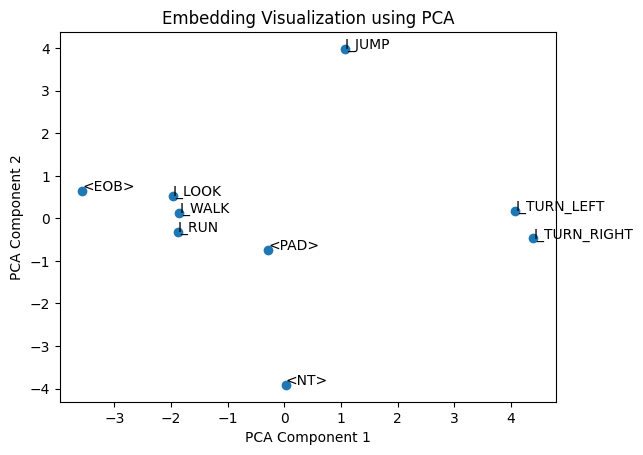

In [18]:
embeddings = tpr.out.weight.data.numpy()
from sklearn.decomposition import PCA

#output_indices = [10,11,12,13,16,21]

pca = PCA(n_components=2)  # for 2D visualization
reduced_embeddings = pca.fit_transform(embeddings)
import matplotlib.pyplot as plt

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# Annotate each point
for i, label in enumerate(output_lang.ind2vocab):
    plt.annotate(output_lang.ind2vocab[label], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title('Embedding Visualization using PCA')
plt.show()

In [ ]:
torch.linalg.matrix_rank(tpr.filler_emb.weight)